In [1]:
%info

In [2]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1588646822737_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Part II:  Analyzing Categories

In [3]:
business = spark.read.json('s3://sta9760-laura-spark-datasets/yelp-dataset/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
print(f'Total Columns: {len(business.dtypes)}')
print(f'Total Rows: {business.count():,}')
business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 209,393
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable

In [6]:
#df.select('business_id','name','city','state','stars','categories').show(5, truncate=True)
business.createOrReplaceTempView('YelpBusiness')
sqldf = spark.sql(
'''
SELECT `business_id`, `name`, `city`, `state`, `categories`
FROM YelpBusiness

'''
)
sqldf.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

## How many unique categories are represented in this dataset?

In [7]:
from pyspark.sql.functions import split, explode, ltrim
df1 = sqldf.withColumn('categories',explode(split('categories',',')))
df1 = df1.withColumn('categories',ltrim(df1.categories))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
#df1 = df1.filter(df1.is_open==1)
df1.select('business_id','categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|      categories|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

In [9]:
df1.select('categories').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business

In [10]:
df2=df1.groupby('categories').count().orderBy("count", ascending=False)
df2.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|         Restaurants|63944|
|            Shopping|34644|
|                Food|32991|
|       Home Services|22487|
|       Beauty & Spas|20520|
|    Health & Medical|19227|
|      Local Services|15783|
|          Automotive|14720|
|           Nightlife|14211|
|                Bars|12400|
|Event Planning & ...|11263|
|         Active Life|10225|
|        Coffee & Tea| 8415|
|             Fashion| 8374|
|           Fast Food| 8106|
|          Sandwiches| 8064|
|American (Traditi...| 7596|
|       Home & Garden| 7331|
|         Hair Salons| 7303|
|               Pizza| 7302|
+--------------------+-----+
only showing top 20 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

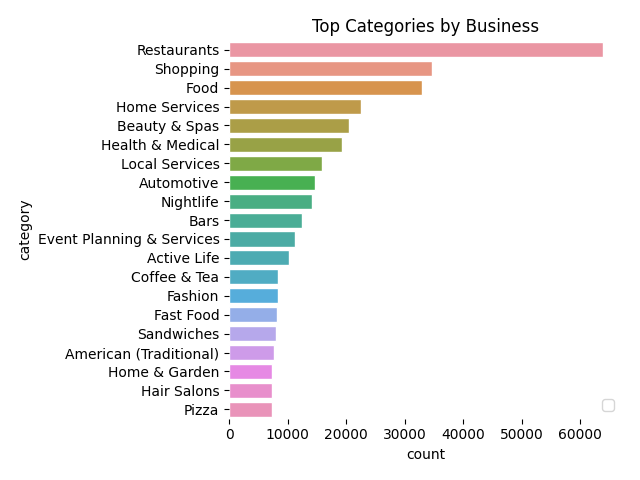

In [14]:
result_pdf = df2.limit(20).toPandas()
#result_pdf.head()
# ax=result_pdf.plot.barh(x='categories', y='count')
# ax.invert_yaxis()
# ax = plt.gca()
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(6)
sns.set(style="whitegrid", color_codes=True)
sns.barplot(result_pdf['count'],result_pdf['categories'])    
plt.title('Top Categories by Business')
plt.xlabel('count')
plt.ylabel('category')
plt.tight_layout()
plt.legend('')
plt.box(False)
%matplot plt

# Part III: Do Yelp Reviews Skew Negative?

In [15]:
review=spark.read.json('s3://sta9760-laura-spark-datasets/yelp-dataset/yelp_academic_dataset_review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
print(f'Total Columns: {len(review.dtypes)}')
print(f'Total Rows: {review.count():,}')
review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 9
Total Rows: 8,021,122
root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

In [50]:
review.createOrReplaceTempView('YelpReview')
review_sqldf = spark.sql(
'''
SELECT business_id, stars, user_id
FROM YelpReview
'''
)
review_sqldf.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+
|         business_id|stars|             user_id|
+--------------------+-----+--------------------+
|-MhfebM0QIsKt87iD...|  2.0|OwjRMXRC0KyPrIlcj...|
|lbrU8StCq3yDfr-QM...|  1.0|nIJD_7ZXHq-FX8byP...|
|HQl28KMwrEKHqhFrr...|  5.0|V34qejxNsCbcgD8C0...|
|5JxlZaqCnk1MnbgRi...|  1.0|ofKDkJKXSKZXu5xJN...|
|IS4cv902ykd8wj1TR...|  4.0|UgMW8bLE0QMJDCkQ1...|
+--------------------+-----+--------------------+
only showing top 5 rows

In [51]:
review_avg=review_sqldf.groupby('business_id').agg({'stars':'mean'})
review_avg.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+
|         business_id|       avg(stars)|
+--------------------+-----------------+
|x1fx7C_tc064cFATj...|3.120967741935484|
|ATeOjZzE3VOI-RW7F...|3.433734939759036|
|kpbhERZoj1eTDRnMV...|2.033333333333333|
|vyu1WGlnHGv2Z2MVE...|              5.0|
|ipFreSFhjClfNETuM...|              2.6|
+--------------------+-----------------+
only showing top 5 rows

In [52]:
business_rating =review_avg.join(business, on="business_id", how="inner").select('avg(stars)','stars', 'name', 'city', 'state')
business_rating.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+-----------+-----+
|        avg(stars)|stars|                name|       city|state|
+------------------+-----+--------------------+-----------+-----+
|  4.11784140969163|  4.0|Delmonico Steakhouse|  Las Vegas|   NV|
|2.3333333333333335|  2.5|Neo-Paws Internat...|    Toronto|   ON|
|             4.375|  4.5| McFarling Law Group|  Las Vegas|   NV|
|3.3333333333333335|  3.5|Volvo of Mississauga|Mississauga|   ON|
|               5.0|  5.0|Andre Agassi Coll...|  Las Vegas|   NV|
+------------------+-----+--------------------+-----------+-----+
only showing top 5 rows

In [54]:
review_skew = business_rating.withColumn("skewpoint", F.round((F.col('avg(stars)')-F.col('stars'))/F.col('stars'), 3))
review_skew.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+-----------+-----+---------+
|        avg(stars)|stars|                name|       city|state|skewpoint|
+------------------+-----+--------------------+-----------+-----+---------+
|  4.11784140969163|  4.0|Delmonico Steakhouse|  Las Vegas|   NV|    0.029|
|2.3333333333333335|  2.5|Neo-Paws Internat...|    Toronto|   ON|   -0.067|
|             4.375|  4.5| McFarling Law Group|  Las Vegas|   NV|   -0.028|
|3.3333333333333335|  3.5|Volvo of Mississauga|Mississauga|   ON|   -0.048|
|               5.0|  5.0|Andre Agassi Coll...|  Las Vegas|   NV|      0.0|
+------------------+-----+--------------------+-----------+-----+---------+
only showing top 5 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

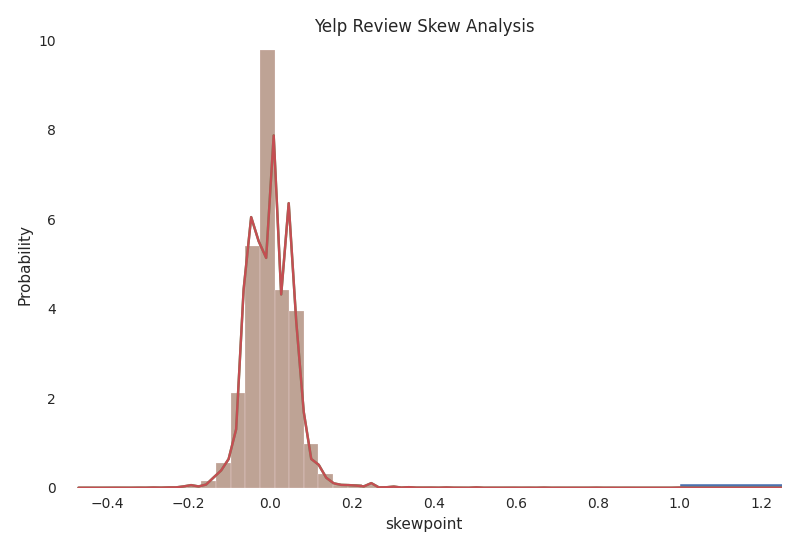

In [55]:
result_pdf = review_skew.toPandas()
sns.distplot(result_pdf['skewpoint'])    
plt.title('Yelp Review Skew Analysis')
plt.tight_layout()
plt.box(False)
plt.xlim(-0.5, 1.25)
plt.ylim(0, 10)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

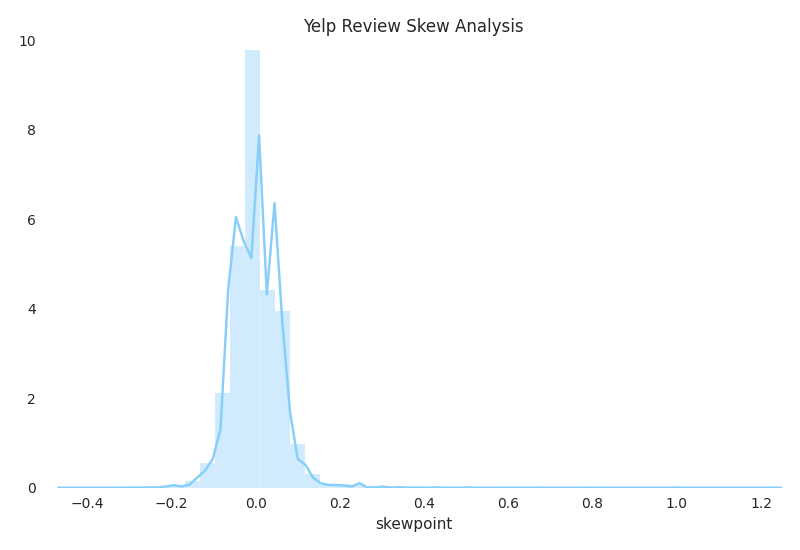

In [56]:
plt.figure()
result_pdf = review_skew.toPandas()
sns.set_style("white")
sns.distplot(result_pdf['skewpoint'],color="lightskyblue")    
plt.title('Yelp Review Skew Analysis')
plt.tight_layout()
plt.box(False)
plt.xlim(-0.5, 1.25)
plt.ylim(0, 10)
%matplot plt

### Do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph.
### A: Most skew poit is close to 0. We can see a slightly negative skewness. So Yelp reviews are little bit negative. We need also plot to plot review amount vs review stars.

In [29]:
review.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+------------------+-------------------+------------------+--------------------+------------------+-------------------------------------+------------------+--------------------+
|summary|         business_id|              cool|               date|             funny|           review_id|             stars|                                 text|            useful|             user_id|
+-------+--------------------+------------------+-------------------+------------------+--------------------+------------------+-------------------------------------+------------------+--------------------+
|  count|             8021122|           8021122|            8021122|           8021122|             8021122|           8021122|                              8021122|           8021122|             8021122|
|   mean|                null|0.5745620126461111|               null|0.4596423044057926|                null|3.7035746370644906|                                 null|1.3228

## Top Rated Business

In [30]:
top_rated = spark.sql(
'''
SELECT business_id, count(*) as reviews
FROM YelpReview
WHERE stars=5
GROUP by business_id
ORDER by 2 desc

'''
)
top_rated.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+
|         business_id|reviews|
+--------------------+-------+
|4JNXUYY8wbaaDmk3B...|   4501|
|RESDUcs7fIiihp38-...|   4247|
|faPVqws-x-5k2CQKD...|   3415|
|vHz2RLtfUMVRPFmd7...|   3290|
|JDZ6_yycNQFTpUZzL...|   3158|
|f4x1YBxkLrZg652xt...|   2848|
|QXV3L_QFGj8r6nWX2...|   2827|
|3kdSl5mo9dWC4clrQ...|   2758|
|DkYS3arLOhA8si5uU...|   2738|
|mDR12Hafvr84ctpsV...|   2661|
+--------------------+-------+
only showing top 10 rows

#### It shows high rating firm is associated with high reveiew count. This does not support our conclusion: Yelp reviews are little negative is true.

In [31]:
stars_reviews = spark.sql(
'''
SELECT stars, count(*) as reviews
FROM YelpReview
GROUP by stars

'''
)
stars_reviews.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+
|stars|reviews|
+-----+-------+
|  1.0|1283897|
|  4.0|1673404|
|  3.0| 842289|
|  2.0| 635072|
|  5.0|3586460|
+-----+-------+

In [32]:
corrMatrix = stars_reviews.toPandas().corr()
print(corrMatrix)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            stars   reviews
stars    1.000000  0.757088
reviews  0.757088  1.000000

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

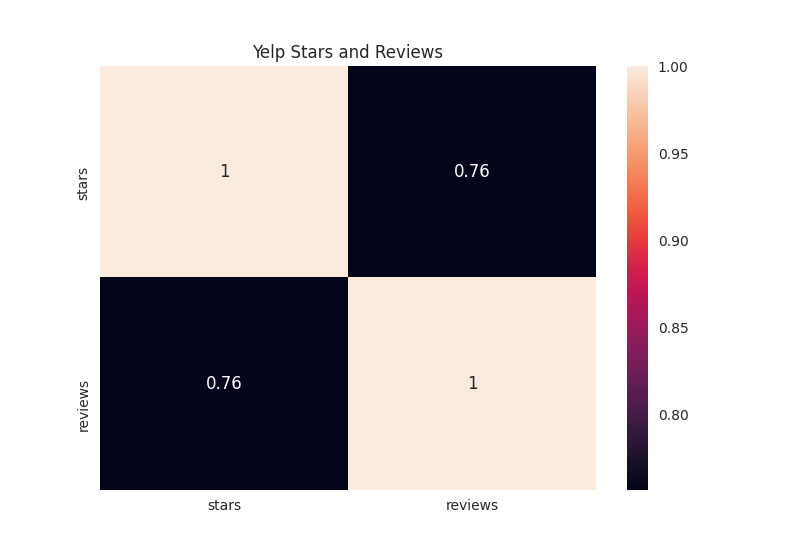

In [34]:
plt.figure()
sns.heatmap(corrMatrix,  annot=True)
plt.title('Yelp Stars and Reviews')
%matplot plt

### Conclusion:
#### We see high correlation beween number of reviews and number of stars. People are only bothering to rate good firms that makes it interesting to use Yelp only to determine if the firm is reviewd at all. If the firm is not rated the unwritten reviews are bad. This does not support our conclusion that Yelp reviews are little negative.


## Correlation Business and rating

In [37]:
business_rating = spark.sql(
'''
SELECT business_id, avg(stars) as rating
FROM YelpReview
GROUP by business_id
ORDER by 2 desc

'''
)
business_rating.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+
|         business_id|rating|
+--------------------+------+
|QKw18nKoUL1M-Y2cz...|   5.0|
|TkC9eXvqbSqy0KVRy...|   5.0|
|_RC0JMGUHRxyQR57t...|   5.0|
|qbZb_xERInR51y7sk...|   5.0|
|QlF8OX8N2t-JM9D5E...|   5.0|
+--------------------+------+
only showing top 5 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

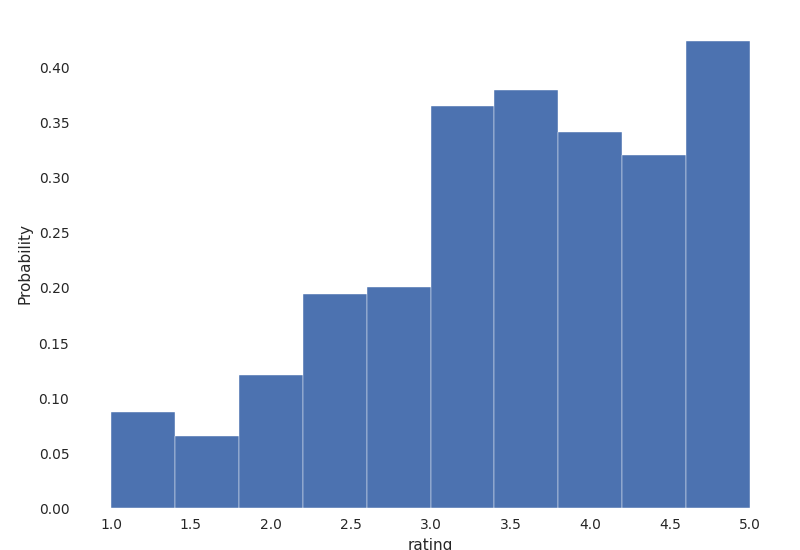

In [40]:
rating_pdf = business_rating.toPandas()
plt.figure()
fig, ax = plt.subplots()
rating_pdf['rating'].plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
plt.tight_layout()
plt.xlabel('rating')
plt.box(False)
%matplot plt

### It also support our conclusion: Yelp reviews are not negative.

# Part IV: Should the Elite be Trusted? 

In [57]:
user=spark.read.json('s3://sta9760-laura-spark-datasets/yelp-dataset/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
print(f'Total Columns: {len(user.dtypes)}')
print(f'Total Rows: {user.count():,}')
user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 22
Total Rows: 1,968,703
root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [59]:
review_compare=review_avg.join(review_sqldf, on="business_id", how="inner")
review_compare.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+-----+--------------------+
|         business_id|      avg(stars)|stars|             user_id|
+--------------------+----------------+-----+--------------------+
|--9e1ONYQuAa-CB_R...|4.11784140969163|  5.0|mBBGHMLDDmtptNIu0...|
|--9e1ONYQuAa-CB_R...|4.11784140969163|  4.0|5WBIwR92ZNVmsG7bR...|
|--9e1ONYQuAa-CB_R...|4.11784140969163|  5.0|3HG4RGeej4dZiMo5s...|
|--9e1ONYQuAa-CB_R...|4.11784140969163|  3.0|bWJWcQyDKtFSvsTW2...|
|--9e1ONYQuAa-CB_R...|4.11784140969163|  5.0|HaqStKX7oqpx5ymDH...|
+--------------------+----------------+-----+--------------------+
only showing top 5 rows

In [60]:
user_review_compare=review_compare.join(user, on="user_id", how="inner")
user_review_compare=user_review_compare.select('avg(stars)','stars', 'elite','review_count')
user_review_compare.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+------------+
|        avg(stars)|stars|               elite|review_count|
+------------------+-----+--------------------+------------+
|            4.0125|  4.0|                    |          55|
| 2.310344827586207|  2.0|                    |           3|
|2.9904761904761905|  4.0|2011,2012,2013,20...|         163|
|3.3333333333333335|  5.0|                    |           7|
|3.5925925925925926|  1.0|                    |           7|
+------------------+-----+--------------------+------------+
only showing top 5 rows

In [67]:
review_skew = user_review_compare.withColumn("skew", F.round((F.col('avg(stars)')-F.col('stars'))/F.col('stars'), 2))
review_skew.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+------------+-----+
|        avg(stars)|stars|               elite|review_count| skew|
+------------------+-----+--------------------+------------+-----+
|            4.0125|  4.0|                    |          55|  0.0|
| 2.310344827586207|  2.0|                    |           3| 0.16|
|2.9904761904761905|  4.0|2011,2012,2013,20...|         163|-0.25|
|2.8392857142857144|  1.0|                    |           7| 1.84|
|3.5925925925925926|  1.0|                    |           7| 2.59|
+------------------+-----+--------------------+------------+-----+
only showing top 5 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

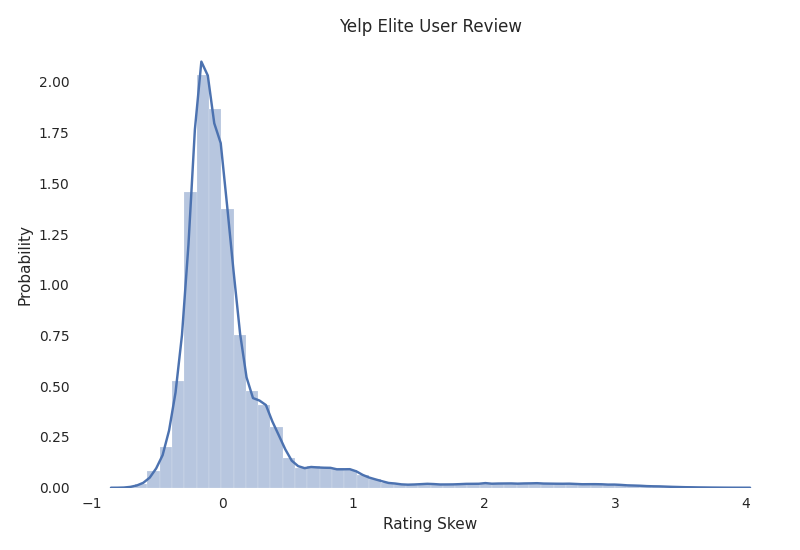

In [68]:
elite_review_skew=review_skew.filter(F.col('elite')!='')
result_pdf = elite_review_skew.toPandas()
plt.figure()
sns.distplot(result_pdf['skew'])    
plt.title('Yelp Elite User Review')
plt.xlabel('Rating Skew')
plt.ylabel('Probability')
plt.tight_layout()
plt.box(False)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

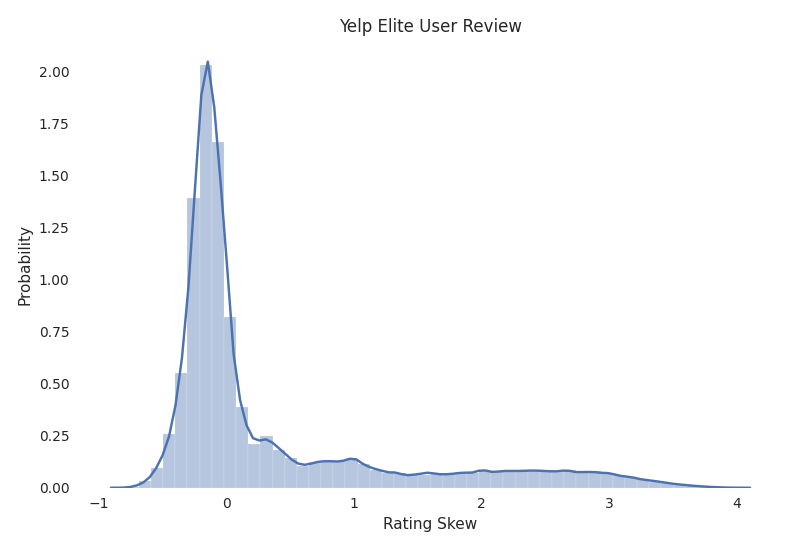

In [69]:
non_elite_review_skew=review_skew.filter(F.col('elite')=='')
result_pdf = non_elite_review_skew.toPandas()
plt.figure()
sns.distplot(result_pdf['skew'])    
plt.title('Yelp Elite User Review')
plt.xlabel('Rating Skew')
plt.ylabel('Probability')
plt.tight_layout()
plt.box(False)
%matplot plt

## Conclusiton: Elite user has no significant different in terms of accurate of the ratings.